<a href="https://colab.research.google.com/github/khaled0625/w4_Transfer_Learning/blob/main/cnn_arabic_letters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub
path = kagglehub.dataset_download("mohdrehanhaider/arabic-characters")

100%|██████████| 6.28M/6.28M [00:00<00:00, 88.4MB/s]

Extracting files...


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
model_conv_2 = torchvision.models.resnet18(weights='IMAGENET1K_V1')

print(model_conv_2)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 196MB/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
# Training set transformation pipeline
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Validation set transformation pipeline
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [5]:
class cnnArabic(nn.Module):
  def __init__(self):
        super(cnnArabic, self).__init__()

        # Define the first convolutional block
        self.conv1 = nn.Conv2d(in_channels=3  , out_channels=16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Define the second convolutional block
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Define the third convolutional block
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Define the layer to flatten the feature maps
        self.flatten = nn.Flatten()

        # Define the fully connected (dense) layers
        # With 224x224 input images, after 3 pooling layers (each reducing by factor of 2),
        # the spatial dimensions become 224 / (2*2*2) = 224 / 8 = 28.
        # So, the flattened size is 128 * 28 * 28.
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 28)


  def forward(self, x):
        # Pass input through the first convolutional block
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        # Pass feature maps through the second convolutional block
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        # Pass feature maps through the third convolutional block
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        # Flatten the output for the fully connected layers
        x = self.flatten(x)

        # Pass the flattened features through the fully connected layers
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout(x)
        x = self.fc2(x)

        # Return the final output logits
        return x

In [6]:
import os
import torch
from torchvision import datasets, transforms

# 1. Define the folder names exactly as seen in your screenshot
TRAIN_DIR_NAME = 'Train Arabic'
TEST_DIR_NAME = 'Test Arabic'

# 2. Fix the Path (The Critical Step)
# We look inside 'path' to see if there is an intermediate folder like "Arabic Character Dataset"
contents = os.listdir(path)
if TRAIN_DIR_NAME not in contents and len(contents) == 1:
    # If we don't see 'Train Arabic' but see one folder (e.g., 'Arabic Character Dataset')
    # We step inside that folder.
    print(f"Stepping inside parent folder: {contents[0]}")
    data_dir = os.path.join(path, contents[0])
else:
    data_dir = path

# 3. Define Transforms (Using 0.5 mean/std for handwriting)
data_transforms = {
    TRAIN_DIR_NAME: transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    TEST_DIR_NAME: transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

# 4. Create Datasets
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in [TRAIN_DIR_NAME, TEST_DIR_NAME]
}

# 5. Create Dataloaders
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2)
    for x in [TRAIN_DIR_NAME, TEST_DIR_NAME]
}
dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN_DIR_NAME, TEST_DIR_NAME]}

# 6. Verify
class_names = image_datasets[TRAIN_DIR_NAME].classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Success!")
print(f"Found {len(class_names)} classes.")
print(f"Sample classes: {class_names[:5]}")
# Based on your screenshot, expected output is numbers like ['1', '10', '11'...]

Stepping inside parent folder: Arabic Character Dataset
Success!
Found 28 classes.
Sample classes: ['1', '10', '11', '12', '13']


In [7]:
def training_loop(model, train_loader, val_loader, loss_function, optimizer, num_epochs, device):
    """
    Trains and validates a PyTorch neural network model.

    Args:
        model: The neural network model to be trained.
        train_loader: DataLoader for the training dataset.
        val_loader: DataLoader for the validation dataset.
        loss_function: The loss function to use for training.
        optimizer: The optimization algorithm.
        num_epochs: The total number of epochs to train for.
        device: The device (e.g., 'cpu' or 'cuda') to run the training on.

    Returns:
        A tuple containing:
        - The trained model.
        - A list of metrics [train_losses, val_losses, val_accuracies].
    """
    # Move the model to the specified device (CPU or GPU)
    model.to(device)

    # Initialize lists to store training and validation metrics
    train_losses = []
    val_losses = []
    val_accuracies = []

    # Print a message indicating the start of the training process
    print("--- Training Started ---")

    # Loop over the specified number of epochs
    for epoch in range(num_epochs):
        # Set the model to training mode
        model.train()
        # Initialize running loss for the current epoch
        running_loss = 0.0
        # Iterate over batches of data in the training loader
        for images, labels in train_loader:
            # Move images and labels to the specified device
            images, labels = images.to(device), labels.to(device)

            # Clear the gradients of all optimized variables
            optimizer.zero_grad()
            # Perform a forward pass to get model outputs
            outputs = model(images)
            # Calculate the loss
            loss = loss_function(outputs, labels)
            # Perform a backward pass to compute gradients
            loss.backward()
            # Update the model parameters
            optimizer.step()

            # Accumulate the training loss for the batch
            running_loss += loss.item() * images.size(0)

        # Calculate the average training loss for the epoch
        epoch_loss = running_loss / len(train_loader.dataset)
        # Append the epoch loss to the list of training losses
        train_losses.append(epoch_loss)

        # Set the model to evaluation mode
        model.eval()
        # Initialize running validation loss and correct predictions count
        running_val_loss = 0.0
        correct = 0
        total = 0
        # Disable gradient calculations for validation
        with torch.no_grad():
            # Iterate over batches of data in the validation loader
            for images, labels in val_loader:
                # Move images and labels to the specified device
                images, labels = images.to(device), labels.to(device)

                # Perform a forward pass to get model outputs
                outputs = model(images)

                # Calculate the validation loss for the batch
                val_loss = loss_function(outputs, labels)
                # Accumulate the validation loss
                running_val_loss += val_loss.item() * images.size(0)

                # Get the predicted class labels
                _, predicted = torch.max(outputs, 1)
                # Update the total number of samples
                total += labels.size(0)
                # Update the number of correct predictions
                correct += (predicted == labels).sum().item()

        # Calculate the average validation loss for the epoch
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        # Append the epoch validation loss to the list
        val_losses.append(epoch_val_loss)

        # Calculate the validation accuracy for the epoch
        epoch_accuracy = 100.0 * correct / total
        # Append the epoch accuracy to the list
        val_accuracies.append(epoch_accuracy)

        # Print the metrics for the current epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_accuracy:.2f}%")

    # Print a message indicating the end of the training process
    print("--- Finished Training ---")

    # Consolidate all metrics into a single list
    metrics = [train_losses, val_losses, val_accuracies]

    # Return the trained model and the collected metrics
    return model, metrics

In [8]:

# Start the training process by calling the training loop function

loss_function = nn.CrossEntropyLoss()
cnn_arabic = cnnArabic() # Fixed: Removed the argument '28'
# Optimizer for the prototype model
optimizer_prototype = optim.Adam(cnn_arabic.parameters(), lr=0.001)

trained_proto_model, training_metrics_proto = training_loop(
    model=cnn_arabic, # Fixed: Changed from cnnArabic to cnn_arabic
    train_loader=dataloaders['Train Arabic'],
    val_loader=dataloaders['Test Arabic'],
    loss_function=loss_function,
    optimizer=optimizer_prototype,
    num_epochs=15,
    device=device
)

--- Training Started ---
Epoch [1/15], Train Loss: 2.2161, Val Loss: 1.4214, Val Accuracy: 55.18%
Epoch [2/15], Train Loss: 1.3300, Val Loss: 0.8739, Val Accuracy: 72.17%
Epoch [3/15], Train Loss: 0.9069, Val Loss: 0.6562, Val Accuracy: 78.96%
Epoch [4/15], Train Loss: 0.6945, Val Loss: 0.6126, Val Accuracy: 79.82%
Epoch [5/15], Train Loss: 0.5667, Val Loss: 0.6052, Val Accuracy: 80.98%
Epoch [6/15], Train Loss: 0.4738, Val Loss: 0.6218, Val Accuracy: 80.36%
Epoch [7/15], Train Loss: 0.4008, Val Loss: 0.5626, Val Accuracy: 83.27%
Epoch [8/15], Train Loss: 0.3557, Val Loss: 0.5758, Val Accuracy: 82.95%
Epoch [9/15], Train Loss: 0.3093, Val Loss: 0.6098, Val Accuracy: 81.79%
Epoch [10/15], Train Loss: 0.2689, Val Loss: 0.6788, Val Accuracy: 82.05%
Epoch [11/15], Train Loss: 0.2437, Val Loss: 0.6397, Val Accuracy: 82.20%
Epoch [12/15], Train Loss: 0.2283, Val Loss: 0.6278, Val Accuracy: 83.54%
Epoch [13/15], Train Loss: 0.2204, Val Loss: 0.6577, Val Accuracy: 82.65%
Epoch [14/15], Train L

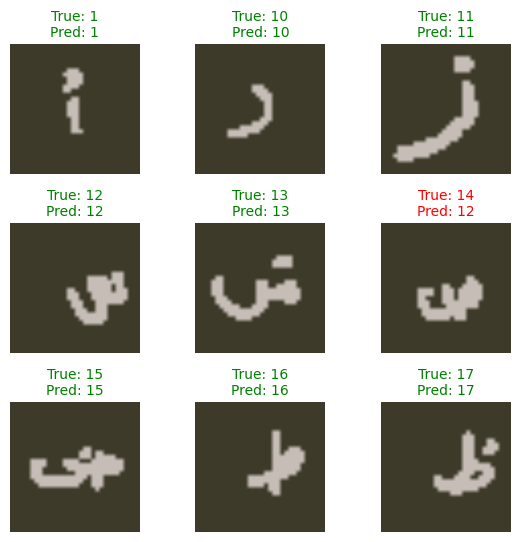

In [12]:
import helper_utils
# Visualize model predictions on a sample of validation images
helper_utils.visualise_predictions(
    model=trained_proto_model,
    data_loader=dataloaders['Test Arabic'],
    device=device,
    grid=(3, 3)
)

In [23]:
# Standard Arabic Alphabet list (28 letters)
# Ensure this order matches your class_names order!
arabic_letters = [
    'أ', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر',
    'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف',
    'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ي'
]

------------------------------
Predicted Class Index: 27
Folder Label: 9
Arabic Letter: ي
Confidence: 95.53%
------------------------------


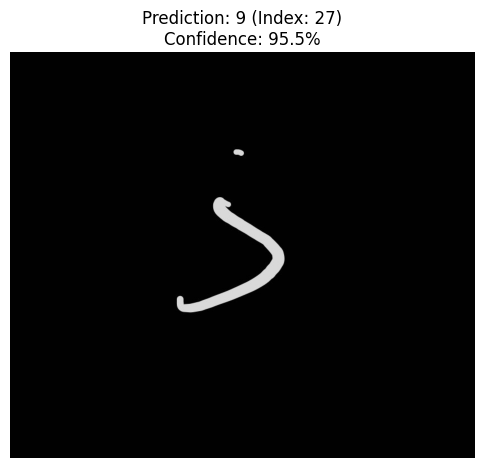

In [25]:
def predict_and_display_arabic(model, image_path, class_names, device):
    # 1. Load Image
    img_display = Image.open(image_path).convert('RGB')

    # 2. Transform
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    image_tensor = transform(img_display).unsqueeze(0).to(device)

    # 3. Predict
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        top_p, top_class = probs.topk(1, dim=1)

        # Get Index and Score
        idx = top_class.item()
        score = top_p.item()

        # Get Folder Name (e.g., "alef" or "0")
        folder_name = class_names[idx]

        # Get Arabic Letter (using the list we defined)
        # We use % 28 just in case the index goes out of bounds, though it shouldn't
        arabic_char = arabic_letters[idx]

    # 4. Print Results to Console (Best for Arabic text)
    print("-" * 30)
    print(f"Predicted Class Index: {idx}")
    print(f"Folder Label: {folder_name}")
    print(f"Arabic Letter: {arabic_char}")  # <--- This prints the correct letter
    print(f"Confidence: {score:.2%}")
    print("-" * 30)

    # 5. Display Image
    plt.figure(figsize=(6, 6))
    plt.imshow(img_display)
    # We display the English folder name on the plot to avoid rendering issues
    plt.title(f"Prediction: {folder_name} (Index: {idx})\nConfidence: {score:.1%}")
    plt.axis('off')
    plt.show()

# --- Usage ---
test_image_path = "/content/photo_2026-01-08_20-02-46.jpg" # Change this

predict_and_display_arabic(trained_proto_model, test_image_path, class_names, device)

In [26]:
!pip install seaborn

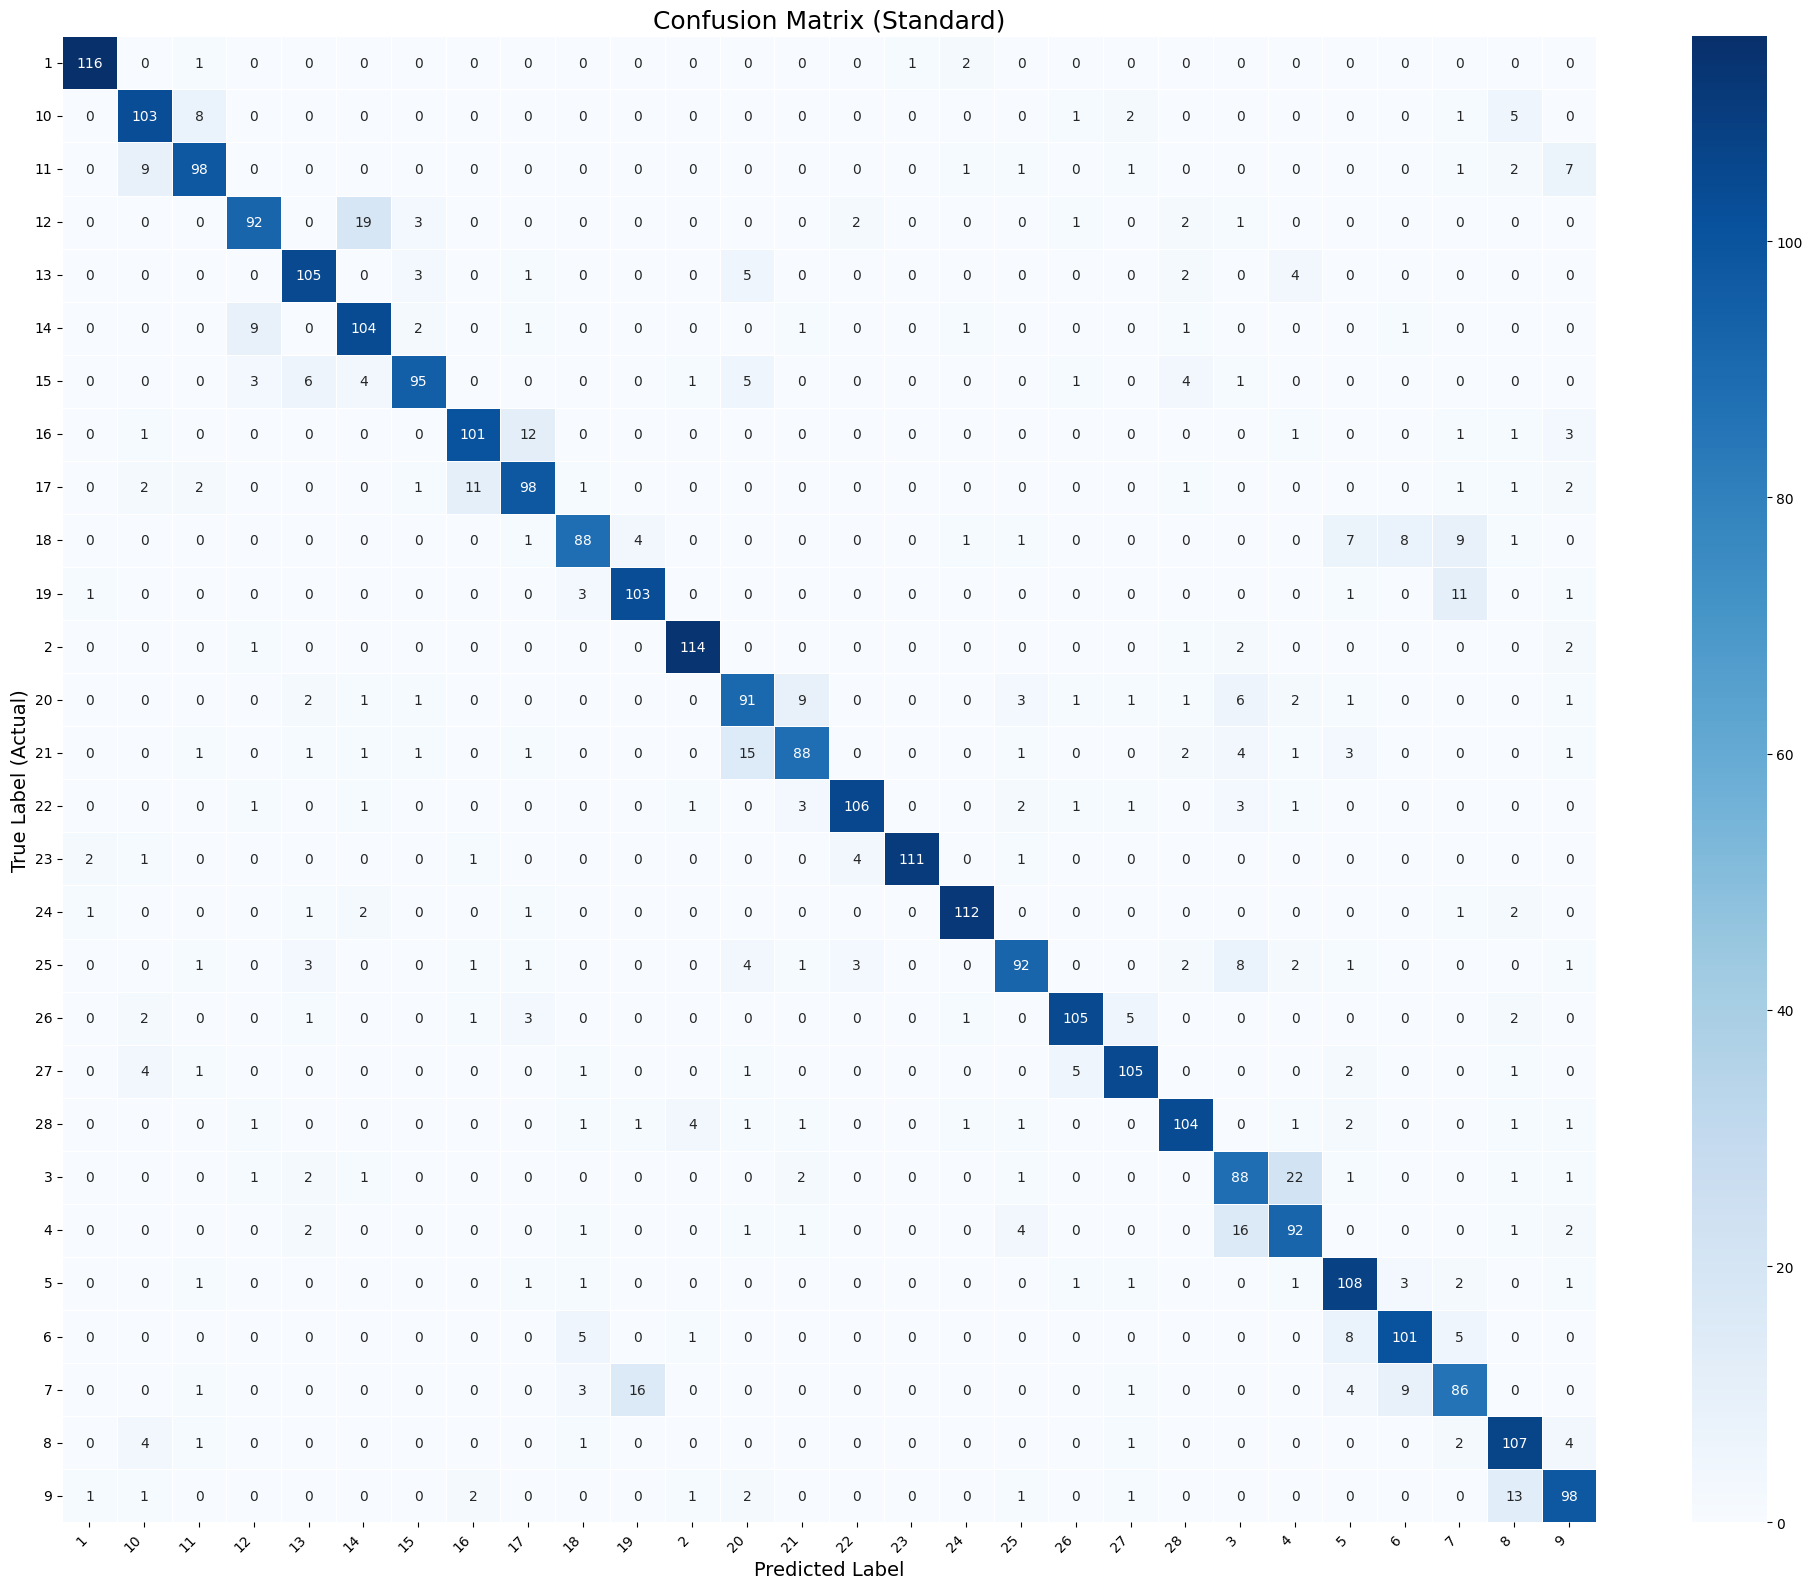

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch
import pandas as pd

def show_confusion_matrix(model, dataloader, class_names, device):
    y_pred = []
    y_true = []

    # 1. Collect Predictions
    model.eval()
    print("Collecting predictions...")
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    # 2. Compute Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    # 3. Create DataFrame for clearer plotting
    # We use class_names (English) to ensure text renders correctly
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

    # 4. Plot Heatmap
    plt.figure(figsize=(20, 16)) # Large size to make all 28 numbers readable

    # annot=True writes the numbers in the boxes
    # cmap='Blues' makes it easy to spot high numbers (darker = higher)
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', linewidths=0.5)

    plt.ylabel('True Label (Actual)', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.title('Confusion Matrix (Standard)', fontsize=18)

    # Adjust ticks for readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    plt.tight_layout()
    plt.show()

# --- Usage ---
show_confusion_matrix(trained_proto_model, dataloaders['Test Arabic'], class_names, device)

In [32]:
# change the metric to f1
